<a href="https://www.kaggle.com/code/shedai/sales-anomaly-detection?scriptVersionId=125221816" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/retail-data-set/file_out2.csv
/kaggle/input/retail-data-set/file_out.csv


# <p style="background-color:#BDBDBD;font-family:newtimeroman;color:#D3463F;font-size:150%;text-align:center;border-radius:10px 10px;">Sales Anomaly Detection</p>

This notebook starts from very basic exploratory data analysis (EDA) with data visualization and analysis. Besides the visual elimination, for this example we will also use the isolation forest algorithm frok SKLearn, you can access the details from following link : <a href ="https://scikit-learn.org/stable/modules/outlier_detection.html#isolation-forest">https://scikit-learn.org/stable/modules/outlier_detection.html#isolation-forest</a>

<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#BDBDBD;font-family:newtimeroman;color:#D3463F;font-size:150%;text-align:center;border-radius:10px 10px;">TABLE OF CONTENTS</p>   
    
* [1. IMPORTING LIBRARIES](#1)
    
* [2. LOADING DATA](#2)
      
* [3. EDA & Visualizations](#3)
    
* [4. Anomaly Detection with Isolation Forest](#4)
    
* [5. Result Set and Evaluation](#5)
    
* [6. Conclusion](#6)
    
* [7. END](#7)

<a class="anchor"  id="1"></a>
# <p style="background-color:#BDBDBD;font-family:newtimeroman;color:#D3463F;font-size:150%;text-align:center;border-radius:10px 10px;"> 1. Importing Libraries</p> 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')

<a id='#2'></a>
# <p style="background-color:#BDBDBD;font-family:newtimeroman;color:#D3463F;font-size:150%;text-align:center;border-radius:10px 10px;">2. Loading Data</p>  
    
Now, we can load the data set and start to analyze it.

In [3]:
df_original = df = pd.read_csv('/kaggle/input/retail-data-set/file_out2.csv')
df.head()

,Unnamed: 0,InvoiceID,Date,ProductID,TotalSales,Discount,CustomerID,Quantity
0,0,328,2019-12-27,1684,796.610169,143.389831,185,4
1,1,329,2019-12-27,524,355.932203,64.067797,185,2
2,2,330,2019-12-27,192,901.694915,162.305085,230,4
3,3,330,2019-12-27,218,182.754237,32.895763,230,1
4,4,330,2019-12-27,247,780.101695,140.418305,230,4


<a id='#3'></a>
# <p style="background-color:#BDBDBD;font-family:newtimeroman;color:#D3463F;font-size:150%;text-align:center;border-radius:10px 10px;">3. EDA and Visualizations</p>  


In [4]:
df.describe()

,Unnamed: 0,InvoiceID,ProductID,TotalSales,Discount,CustomerID,Quantity
count,29103.000000,29103.000000,29103.000000,29103.000000,29103.000000,29103.000000,29103.000000
mean,14551.000000,7221.321445,869.953819,2552.679147,451.325294,247.290279,5.440367
std,8401.456778,3443.397539,583.414204,4568.256400,650.359457,138.701207,6.804637
min,0.000000,0.000000,0.000000,0.000000,-0.004694,0.000000,0.000000
25%,7275.500000,4919.000000,379.000000,779.661017,137.288136,134.000000,2.000000
50%,14551.000000,7588.000000,660.000000,1366.101695,244.067797,230.000000,4.000000
75%,21826.500000,9536.000000,1456.000000,2847.457627,508.658644,349.000000,4.000000
max,29102.000000,14078.000000,1939.000000,332574.460000,14110.169492,506.000000,250.000000


Let's understand the ditribution of data among columns with number of unique records in each column:

In [5]:
df.nunique()

Unnamed: 0    29103
InvoiceID     14079
Date           1268
ProductID      1940
TotalSales     7013
Discount       6797
CustomerID      507
Quantity         59
dtype: int64

<AxesSubplot:>

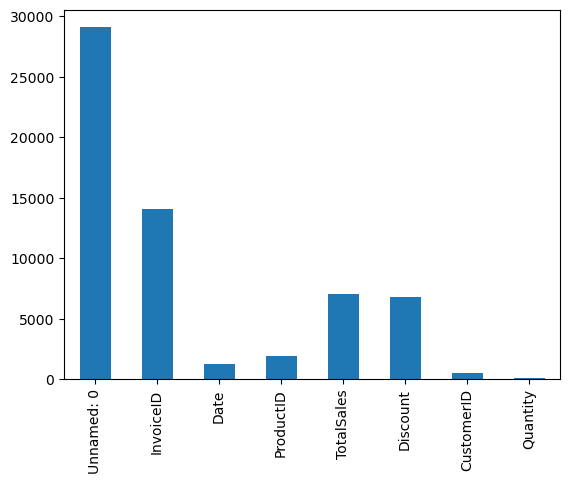

In [6]:
df.nunique().plot.bar()

Visually it is about 2 times for the first row (row id) to invoice id. We can say, the average number of rows per invoice is about 2. Date column is about 1/20 of total records, which means for each day we have about 20 rows or 10 invoices. Finally the total number of customers is 507, which is 1/60 of the total number of rows, so we can understand for each customer we have about 60 items sold, about 3 different dates we have invoices. 

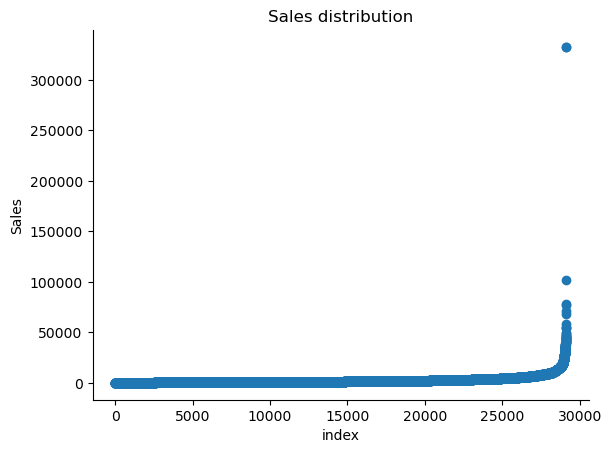

In [7]:
plt.scatter(range(df.shape[0]), np.sort(df['TotalSales'].values))
plt.xlabel('index')
plt.ylabel('Sales')
plt.title("Sales distribution")
sns.despine()

for all the sales, the distribution shows the 'Total Sales' amount is close to each other, but for about 5% of the sales there are huge amounts. Also 1 point is obviously outlier in the sales. This might be the first outlier / **anomaly** we have found. Let's dig it mor:

In [8]:
df.sort_values('TotalSales', ascending = False).head(10)

,Unnamed: 0,InvoiceID,Date,ProductID,TotalSales,Discount,CustomerID,Quantity
13297,13297,261,2020-11-17,543,332574.460000,-0.003959,420,2
12152,12152,305,2020-11-16,543,332383.010000,0.000000,420,2
22865,22865,14046,2022-04-15,1068,101444.400000,0.000000,364,18
26654,26654,12242,2022-12-15,1241,78389.830508,14110.169492,411,100
26644,26644,13298,2022-11-30,1241,77542.372881,13957.627119,17,100
26454,26454,12836,2022-09-23,1158,70762.711864,12737.288136,363,100
26858,26858,11908,2022-11-09,1291,68474.576271,12325.423729,269,40
12438,12438,6155,2020-07-13,192,58474.576270,10525.423730,230,250
24178,24178,8342,2022-07-28,626,55233.050847,9941.949153,57,79
28397,28397,11242,2023-02-07,650,54237.288135,9762.711865,15,64


here, we can see the first 2 rows are very high and there is no smooth connection to the rest of the dataset. Also the quantity column shows us these two rows are impossible with unit prices. Let's create an anomaly result set and start collecting those rows to the result data set:

In [9]:
# we create a df_anomaly dataframe for the anomalies and starting to collect 
# anomalies with 2 rows in the total sales column.
df_anomaly = df.sort_values('TotalSales', ascending = False).head(2)
df_anomaly.head()

,Unnamed: 0,InvoiceID,Date,ProductID,TotalSales,Discount,CustomerID,Quantity
13297,13297,261,2020-11-17,543,332574.46,-0.003959,420,2
12152,12152,305,2020-11-16,543,332383.01,0.000000,420,2


Let's also remove the anomalies from the original dataset:

In [10]:
list(df.sort_values('TotalSales', ascending = False).head(2).index)

[13297, 12152]

In [11]:
df = df.drop(list(df.sort_values('TotalSales', ascending = False).head(2).index))
df.sort_values('TotalSales', ascending = False).head(10)

,Unnamed: 0,InvoiceID,Date,ProductID,TotalSales,Discount,CustomerID,Quantity
22865,22865,14046,2022-04-15,1068,101444.400000,0.000000,364,18
26654,26654,12242,2022-12-15,1241,78389.830508,14110.169492,411,100
26644,26644,13298,2022-11-30,1241,77542.372881,13957.627119,17,100
26454,26454,12836,2022-09-23,1158,70762.711864,12737.288136,363,100
26858,26858,11908,2022-11-09,1291,68474.576271,12325.423729,269,40
12438,12438,6155,2020-07-13,192,58474.576270,10525.423730,230,250
24178,24178,8342,2022-07-28,626,55233.050847,9941.949153,57,79
28397,28397,11242,2023-02-07,650,54237.288135,9762.711865,15,64
26851,26851,13050,2022-10-28,1291,54237.288135,9762.711865,17,32
28509,28509,13871,2023-02-22,1167,49576.271186,8923.728814,211,50


Let's see the unit price distribution and check for anomalies:

In [12]:
df['UnitPrice'] = df['TotalSales'] / df['Quantity']
df.sort_values('UnitPrice',ascending=False).head(10)

,Unnamed: 0,InvoiceID,Date,ProductID,TotalSales,Discount,CustomerID,Quantity,UnitPrice
12149,12149,302,2020-07-27,1854,26443.740000,0.000000,122,2,13221.870000
28173,28173,13761,2023-02-02,1211,17372.881356,3127.118644,246,2,8686.440678
26128,26128,12825,2022-09-20,944,16101.694915,2898.305085,232,2,8050.847458
26287,26287,13335,2022-12-05,1103,30508.474576,5491.525424,246,4,7627.118644
26288,26288,13335,2022-12-05,1104,30508.474576,5491.525424,246,4,7627.118644
26895,26895,13300,2022-11-30,1302,29661.016949,5338.983051,487,4,7415.254237
29098,29098,11092,2023-01-13,1644,6573.000000,1183.140000,269,1,6573.000000
29073,29073,11080,2023-01-10,1644,6573.000000,1183.140000,269,1,6573.000000
26188,26188,13349,2022-12-07,994,12398.305085,2231.694915,233,2,6199.152542
28766,28766,13950,2023-03-10,1084,12033.898305,2166.101695,419,2,6016.949153


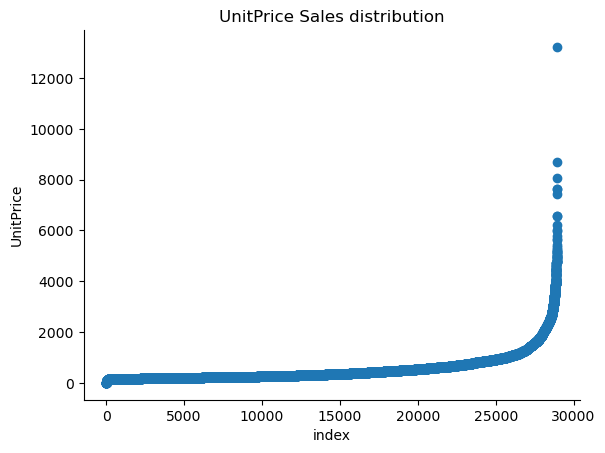

In [13]:
plt.scatter(range(df.shape[0]), np.sort(df['UnitPrice'].values))
plt.xlabel('index')
plt.ylabel('UnitPrice')
plt.title("UnitPrice Sales distribution")
sns.despine()

We can also find a another sales record with a very high unit price, which might be another anomaly. Let's add this record to the anomalies also:

In [14]:
df_anomaly = df_anomaly.append(
    df.sort_values('UnitPrice',ascending=False).head(1))
df_anomaly.head()

,Unnamed: 0,InvoiceID,Date,ProductID,TotalSales,Discount,CustomerID,Quantity,UnitPrice
13297,13297,261,2020-11-17,543,332574.46,-0.003959,420,2,NaN
12152,12152,305,2020-11-16,543,332383.01,0.000000,420,2,NaN
12149,12149,302,2020-07-27,1854,26443.74,0.000000,122,2,13221.87


In [15]:
df = df.drop(list(df.sort_values('UnitPrice',ascending=False).head(1).index))
df.head()

,Unnamed: 0,InvoiceID,Date,ProductID,TotalSales,Discount,CustomerID,Quantity,UnitPrice
0,0,328,2019-12-27,1684,796.610169,143.389831,185,4,199.152542
1,1,329,2019-12-27,524,355.932203,64.067797,185,2,177.966102
2,2,330,2019-12-27,192,901.694915,162.305085,230,4,225.423729
3,3,330,2019-12-27,218,182.754237,32.895763,230,1,182.754237
4,4,330,2019-12-27,247,780.101695,140.418305,230,4,195.025424


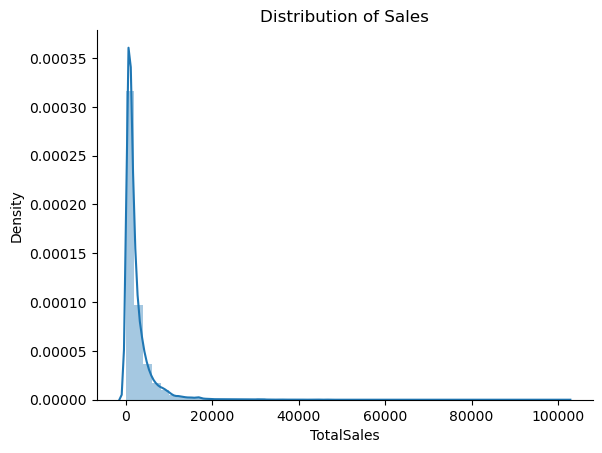

In [16]:
sns.distplot(df['TotalSales'])
plt.title("Distribution of Sales")
sns.despine()

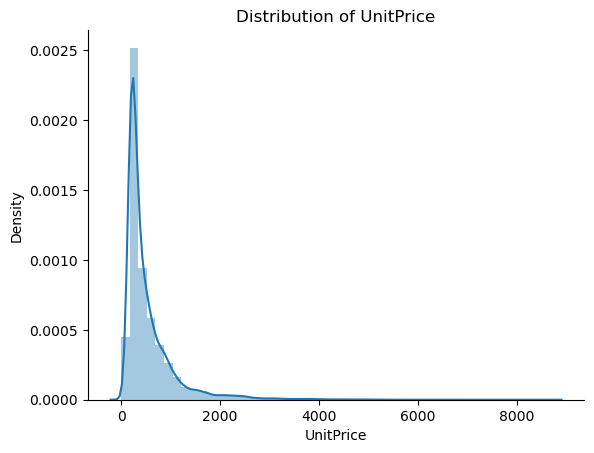

In [17]:
sns.distplot(df['UnitPrice'])
plt.title("Distribution of UnitPrice")
sns.despine()

<a id='#4'></a>
# <p style="background-color:#BDBDBD;font-family:newtimeroman;color:#D3463F;font-size:150%;text-align:center;border-radius:10px 10px;">4. Anomaly Detection with Isolation Forest</p>  


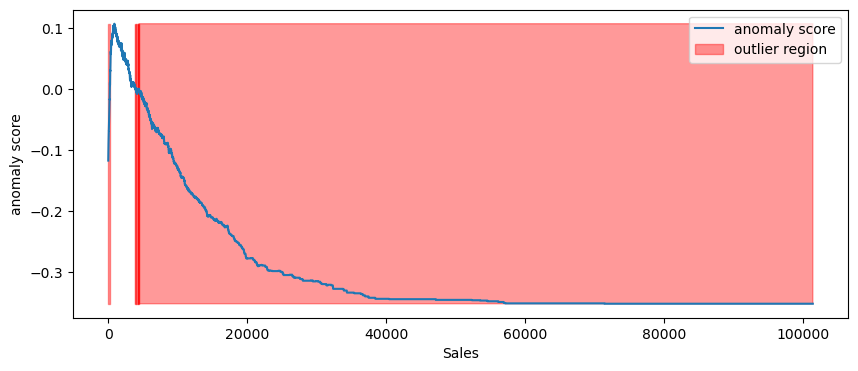

In [18]:
isolation_forest = IsolationForest(n_estimators=100)
isolation_forest.fit(df['TotalSales'].values.reshape(-1, 1))

xx = np.linspace(df['TotalSales'].min(), df['TotalSales'].max(), len(df)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)

plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Sales')
plt.show();

In [19]:
df['AnomalyScore'] = anomaly_score
df.sort_values('AnomalyScore',ascending = False).head()

,Unnamed: 0,InvoiceID,Date,ProductID,TotalSales,Discount,CustomerID,Quantity,UnitPrice,AnomalyScore
253,253,489,2019-07-06,234,724.576271,130.423729,80,2,362.288136,0.107647
252,252,489,2019-07-06,207,1835.593220,330.406780,80,4,458.898305,0.106420
249,249,487,2019-07-06,814,1491.525424,268.474576,13,8,186.440678,0.105990
250,250,488,2019-07-06,814,1278.983051,230.216949,226,7,182.711864,0.105431
251,251,489,2019-07-06,254,2616.949152,471.050848,80,8,327.118644,0.105376


Let's get the top 10 from the Total Sales anomalies:

In [20]:
df_anomaly = pd.concat([df_anomaly,
        df.sort_values('AnomalyScore',ascending = True).head(10) ]
)
df_anomaly.head()

,Unnamed: 0,InvoiceID,Date,ProductID,TotalSales,Discount,CustomerID,Quantity,UnitPrice,AnomalyScore
13297,13297,261,2020-11-17,543,332574.460000,-0.003959,420,2,NaN,NaN
12152,12152,305,2020-11-16,543,332383.010000,0.000000,420,2,NaN,NaN
12149,12149,302,2020-07-27,1854,26443.740000,0.000000,122,2,13221.870000,NaN
29102,29102,11096,2023-01-14,351,5813.559322,1046.440678,423,4,1453.389831,-0.352421
23359,23359,7843,2022-05-14,578,2881.355932,518.644068,420,4,720.338983,-0.352421


In [21]:
df = df.drop(
    list(df.sort_values('AnomalyScore',ascending = False).head(10).index))
df.head()

,Unnamed: 0,InvoiceID,Date,ProductID,TotalSales,Discount,CustomerID,Quantity,UnitPrice,AnomalyScore
0,0,328,2019-12-27,1684,796.610169,143.389831,185,4,199.152542,-0.117246
1,1,329,2019-12-27,524,355.932203,64.067797,185,2,177.966102,-0.112989
2,2,330,2019-12-27,192,901.694915,162.305085,230,4,225.423729,-0.107633
3,3,330,2019-12-27,218,182.754237,32.895763,230,1,182.754237,-0.105232
4,4,330,2019-12-27,247,780.101695,140.418305,230,4,195.025424,-0.105232


In [22]:
df[df['UnitPrice'].isna()].head()

,Unnamed: 0,InvoiceID,Date,ProductID,TotalSales,Discount,CustomerID,Quantity,UnitPrice,AnomalyScore
2328,2328,1930,2019-10-05,885,0.0,0.0,17,0,NaN,-0.089030
6533,6533,4718,2019-04-13,751,0.0,0.0,404,0,NaN,-0.291819
8706,8706,289,2019-03-23,1830,0.0,0.0,430,0,NaN,-0.316298
8707,8707,291,2019-10-21,224,0.0,0.0,276,0,NaN,-0.316298
8708,8708,262,2019-11-18,925,0.0,0.0,364,0,NaN,-0.316298


In [23]:
df['UnitPrice'].isna().sum()

158

There are 158 rows with NaN values in UnitPrice column. The reason is Quantity of these rows are 0. So we can get rid of these rows:

In [24]:
df=df.dropna()
df.head()

,Unnamed: 0,InvoiceID,Date,ProductID,TotalSales,Discount,CustomerID,Quantity,UnitPrice,AnomalyScore
0,0,328,2019-12-27,1684,796.610169,143.389831,185,4,199.152542,-0.117246
1,1,329,2019-12-27,524,355.932203,64.067797,185,2,177.966102,-0.112989
2,2,330,2019-12-27,192,901.694915,162.305085,230,4,225.423729,-0.107633
3,3,330,2019-12-27,218,182.754237,32.895763,230,1,182.754237,-0.105232
4,4,330,2019-12-27,247,780.101695,140.418305,230,4,195.025424,-0.105232


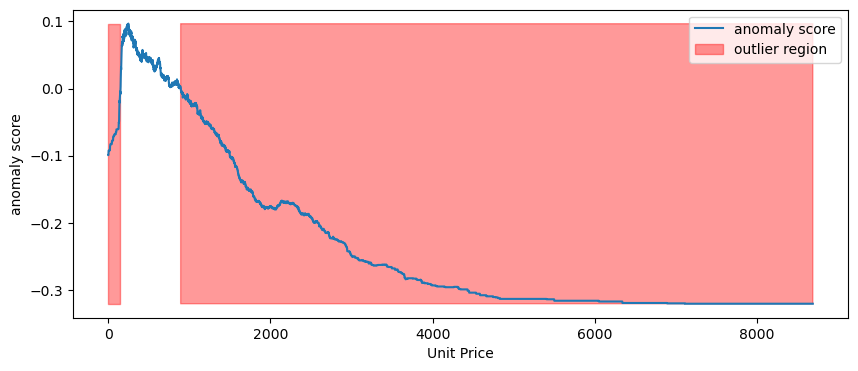

In [25]:
isolation_forest = IsolationForest(n_estimators=100)
isolation_forest.fit(df['UnitPrice'].values.reshape(-1, 1))

xx = np.linspace(df['UnitPrice'].min(), df['UnitPrice'].max(), len(df)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)

plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Unit Price')
plt.show();

In [26]:
df['AnomalyScore'] = anomaly_score
df.sort_values('AnomalyScore',ascending = True).head()

,Unnamed: 0,InvoiceID,Date,ProductID,TotalSales,Discount,CustomerID,Quantity,UnitPrice,AnomalyScore
29102,29102,11096,2023-01-14,351,5813.559322,1046.440678,423,4,1453.389831,-0.320728
25457,25457,11838,2022-11-02,617,2044.915254,368.084746,181,4,511.228814,-0.320728
25458,25458,11861,2022-11-04,617,2152.542373,387.457627,250,4,538.135593,-0.320728
25459,25459,11864,2022-11-05,617,4305.084746,774.915254,404,8,538.135593,-0.320728
25460,25460,11865,2022-11-05,617,2556.144068,460.105932,469,5,511.228814,-0.320728


<a id='#5'></a>
# <p style="background-color:#BDBDBD;font-family:newtimeroman;color:#D3463F;font-size:150%;text-align:center;border-radius:10px 10px;">5. Result Set and OutputFile</p>  


In [27]:
df_anomaly = pd.concat([df_anomaly,
        df.sort_values('AnomalyScore',ascending = False).head(10) ]
)
df_anomaly

,Unnamed: 0,InvoiceID,Date,ProductID,TotalSales,Discount,CustomerID,Quantity,UnitPrice,AnomalyScore
13297,13297,261,2020-11-17,543,332574.460000,-0.003959,420,2,NaN,NaN
12152,12152,305,2020-11-16,543,332383.010000,0.000000,420,2,NaN,NaN
12149,12149,302,2020-07-27,1854,26443.740000,0.000000,122,2,13221.870000,NaN
29102,29102,11096,2023-01-14,351,5813.559322,1046.440678,423,4,1453.389831,-0.352421
23359,23359,7843,2022-05-14,578,2881.355932,518.644068,420,4,720.338983,-0.352421
23360,23360,7844,2022-05-14,379,3389.830508,610.169492,181,8,423.728814,-0.352421
23361,23361,7844,2022-05-14,1845,2152.542373,387.457627,181,4,538.135593,-0.352421
23362,23362,7845,2022-05-14,1844,1779.661017,320.338983,362,1,1779.661017,-0.352421
23363,23363,7846,2022-05-14,379,13559.322034,2440.677966,25,32,423.728814,-0.352421
23364,23364,7847,2022-05-16,1347,885.593220,159.406780,499,1,885.593220,-0.352421


In [28]:
df_anomaly.to_csv('anomalies.csv')

<a id='#6'></a>
# <p style="background-color:#BDBDBD;font-family:newtimeroman;color:#D3463F;font-size:150%;text-align:center;border-radius:10px 10px;">6. Conclusion</p> 
We have started with a sales data in retail industry and visually checked for the Total Sales and Unit Price values. There are 3 rows visually detected as anomaly and we have also added the 10 rows from each of Total Sales and Unit Price column anomaly scores. We might also add the Quantity == 0 rows to anomaly but we have accepted these 158 rows as dirty data and removed them from the dataset. 

<a id='#7'></a>
# <p style="background-color:#BDBDBD;font-family:newtimeroman;color:#D3463F;font-size:150%;text-align:center;border-radius:10px 10px;">7. END</p>
Hello, my name is Sadi Evren SEKER and this is a notebook just for fun. My other notebooks in Kaggle: <a href="https://www.kaggle.com/shedai/code">https://www.kaggle.com/shedai/code</a>



You can reach me by <a href = "https://www.sadievrenseker.com">https://www.sadievrenseker.com</a> (my homepage) or my udemy courses ( <a href="https://www.udemy.com/user/sadievrenseker/">https://www.udemy.com/user/sadievrenseker/</a> ) or my youtube channel ( <a href ="https://www.youtube.com/@dataconcepts">https://www.youtube.com/@dataconcepts </a> ) or my linkedin profile ( <a href = "https://www.linkedin.com/in/sadiseker/"> https://www.linkedin.com/in/sadiseker/</a>), bests.